In [1]:
import pandas as pd
import numpy as np
import time
import datetime
import os
import pickle
from Bio import Entrez
import requests
from bs4 import BeautifulSoup
from collections import defaultdict

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import gensim
from gensim.summarization.summarizer import summarize
from gensim.summarization import keywords
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from ast import literal_eval
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

In [2]:
base_dir='/Volumes/Yuchen_Drive/Insight/OncoMatch'
out_dir='/Volumes/Yuchen_Drive/Insight/OncoMatch/models_w2v'
abstract_df=pd.read_csv(os.path.join(base_dir,'data/abstract_citation_annot_df_50930.csv'),index_col='pmid')
cancer2pmid_dict=pickle.load(open(os.path.join(base_dir, "data/cancer2pmid_dict.pkl"),"rb"))

In [3]:
abstract_df.shape

(50930, 37)

In [4]:
print('Total number of abstracts: {}'.format(abstract_df.shape[0]))

Total number of abstracts: 50930


In [5]:
stop_word1 = gensim.parsing.preprocessing.STOPWORDS   ## 337
stop_word2 = nltk.corpus.stopwords.words('english')   ## 179
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
stop_words = set(list(stop_word1)+stop_word2+list(punct))   ## 448

In [6]:
## Method 1
class MySentences(object):
    """ Credits go to https://www.kaggle.com/reiinakano/basic-nlp-bag-of-words-tf-idf-word2vec-lstm
        MySentences is a generator to produce a list of tokenized sentences 
    
    Takes a list of numpy arrays containing documents.
    
    Args:
        arrays: List of arrays, where each element in the array contains a document.
    """
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    # print(sent)
                    yield [WordNetLemmatizer().lemmatize(token).lower() for token in nltk.word_tokenize(sent) if len(token)>1 and token.lower() not in stop_words]

In [8]:
## Method 1
text_array = abstract_df.abstract.values
print('length of text_array: {}'.format(len(text_array)))

length of text_array: 50930


In [9]:
## Method 1
text_corpus=MySentences(text_array)
print(next(iter(text_corpus)))

['chronic', 'myelogenous', 'leukemia', 'cml', 'myeloproliferative', 'disorder', 'follows', 'characteristic', 'clinical', 'course', 'chronic', 'phase', 'variable', 'duration', 'precedes', 'accelerated', 'ultimately', 'blastic', 'phase', 'generally', 'fatal']


In [27]:
## Method 1_mincount2
#word2vec=gensim.models.Word2Vec(text_corpus,size=100, window=5, min_count=2, workers=4)
location = os.path.join(base_dir, 'models_w2v/doctor_recommendation_w2vmodel_dim100_mincount2.w2v')
#word2vec.save(location)
print('Model done training. Saving to {}'.format(location))
word2vec = gensim.models.Word2Vec.load(location)

Model done training. Saving to /Volumes/Yuchen_Drive/Insight/OncoMatch/models_w2v/doctor_recommendation_w2vmodel_dim100_mincount2.w2v


In [10]:
## Method 1_mincount2_dim300
#word2vec=gensim.models.Word2Vec(text_corpus,size=300, window=5, min_count=2, workers=4)
location = os.path.join(base_dir, 'models_w2v/doctor_recommendation_w2vmodel_dim300_mincount2.w2v')
#word2vec.save(location)
print('Model done training. Saving to {}'.format(location))
word2vec = gensim.models.Word2Vec.load(location)

Model done training. Saving to /Volumes/Yuchen_Drive/Insight/OncoMatch/models_w2v/doctor_recommendation_w2vmodel_dim300_mincount2.w2v


In [11]:
## get embedding dimension of word2vec (dimensionality of the word vectors)
dim=len(word2vec.wv.syn0[0])
print('The dimension of the embedding matrix for word2vec is {}'.format(dim))

The dimension of the embedding matrix for word2vec is 300


In [12]:
## get size of the vocabulary_mincount2
print('Attributes for word2vec_mincount2:')
print('Vocabulary size: {}'.format(len(word2vec.wv.index2word)))
print('Sample words in the vocabulary: {}'.format(word2vec.wv.index2word[:10]))
print('embedding matrix shape: {}'.format(word2vec.wv.vectors.shape))

Attributes for word2vec_mincount2:
Vocabulary size: 83839
Sample words in the vocabulary: ['patient', 'cancer', 'cell', 'tumor', 'survival', 'treatment', 'study', 'therapy', 'disease', 'clinical']
embedding matrix shape: (83839, 300)


In [14]:
## get vector representation for word 'cyclin'
print(len(word2vec.wv['cancer']))
print("Vector representation for 'cyclin': {}".format(word2vec.wv['cancer']))

300
Vector representation for 'cyclin': [ 1.1789465  -1.3757324  -0.39036578 -1.3379644   0.82750887  1.8643337
 -0.5241257   0.40892473 -1.1053663   1.2282484  -0.28931636  0.15974405
  1.1562427  -1.206813   -0.8997953   0.29312932 -1.0029075   0.43363672
  0.20870923  0.98929405  0.04243967  1.2436551  -0.15244405  0.17404369
 -1.509726   -0.42231095 -0.55436206 -0.67065316  2.5220754   0.8067221
 -1.3885901   1.4518783  -1.4346932   1.0983518  -1.4019679   1.9144313
 -0.4755491   0.5297261   1.3184509  -0.11146162 -0.13373101 -2.4961023
  0.07897426 -1.0497311  -0.9545327  -0.60824764 -1.2815638  -0.08909608
 -1.1058238  -2.3536265   1.9138979  -1.316358    0.81449234 -0.84159374
  0.9236009   2.139535    1.2172855   1.4871627  -0.40615675  0.7979262
  0.2120738  -2.1310763  -0.70182943 -1.397219   -0.09446929  0.06290232
  0.5196358   1.9228766   0.8319319  -0.30079985  1.0793283  -1.0877444
  0.14827876  1.4465362  -0.3638882   0.8907661  -0.99446696  0.19716778
 -0.72475725 -0.1

In [15]:
## get 'most_similar' words
result,scores = zip(*word2vec.most_similar(positive=['benign'],topn=30))
print(result)

('atypical', 'atypia', 'nonmalignant', 'non-neoplastic', 'hyperplasia', 'dysplastic', 'fibrous', 'uterus', 'leiomyoma', 'phyllode', 'endometrium', 'glandular', 'cystic', 'indeterminate', 'suspicious', 'multicentric', 'cyst', 'hyperplastic', 'multifocal', 'epithelium', 'intraepithelial', 'histiocytoma', 'ipmns', 'normal-appearing', 'ipmn', 'bbd', 'nonneoplastic', 'ovary', 'melanocytic', 'morphologically')


In [16]:
## get 'most_similar' words
result,scores = zip(*word2vec.most_similar(positive=['aggressive'],topn=30))
print(result)

('indolent', 'lethal', 'typically', 'curable', 'incurable', 'especially', 'rare', 'usually', 'fatal', 'recur', 'heterogeneous', 'certain', 'uncommon', 'particularly', 'historically', 'behave', 'aggressiveness', 'chemoresistant', 'insidious', 'challenging', 'infiltrative', 'prognosis', 'typical', 'poorly', 'multimodality', 'malignant', 'disseminated', 'tend', 'devastating', 'arise')


In [100]:
index_list=[]
result1,scores = zip(*word2vec.most_similar(positive=['benign'], topn=50))
result2,scores = zip(*word2vec.most_similar(positive=['aggressive'], topn=50))
word_list=list(result1)+list(result2)
for word in word_list:
    index_list.append(word2vec.wv.index2word.index(word))
tsne = TSNE()
embed_tsne = tsne.fit_transform(word2vec.wv.vectors[index_list, :])
embed_df=pd.DataFrame({'word':np.array(word_list),'tsne1':embed_tsne[:,0],'tsne2':embed_tsne[:,1],'color':np.append(np.repeat('benign',len(embed_tsne)//2),np.repeat('malignant',len(embed_tsne)//2))})

In [101]:
word2vec.wv.vectors[:, :].shape

(83839, 300)

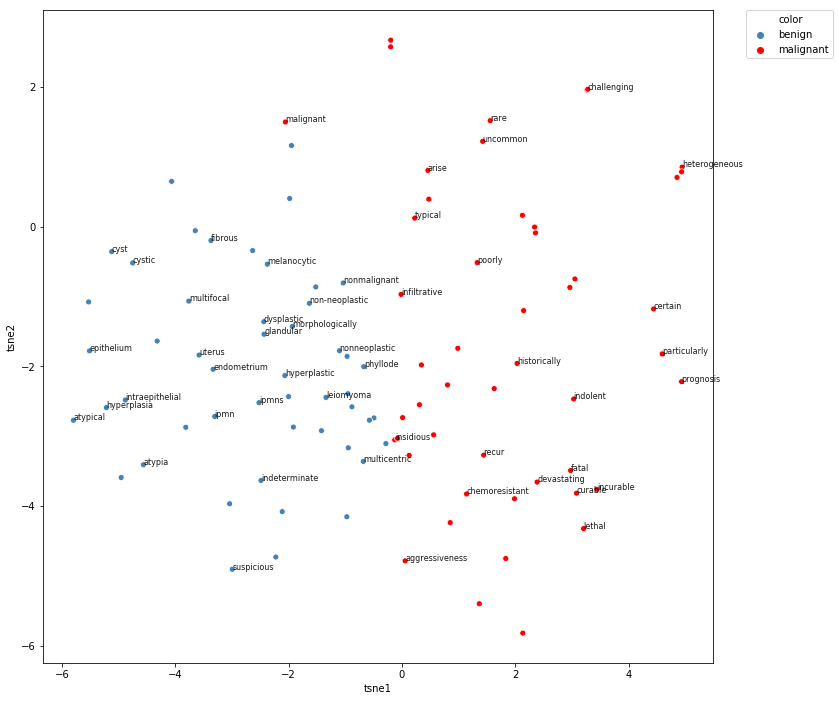

In [102]:
fig, ax = plt.subplots(figsize=(12, 12))
word_to_print=['non-neoplastic', 'atypical', 'atypia', 'nonmalignant', 'hyperplasia', 'dysplastic', 'uterus', 'endometrium', 'leiomyoma', 'fibrous', 'cystic', 'glandular', 'cyst', 'hyperplastic', 'phyllode', 'indeterminate', 'ipmn', 'ipmns', 'suspicious', 'intraepithelial', 'epithelium', 'multifocal', 'multicentric', 'polyp', 'melanocytic', 'grossly', 'nonneoplastic', 'morphologically',
               'indolent', 'lethal', 'curable', 'rare', 'incurable', 'uncommon', 'particularly', 'certain', 'recur', 'fatal', 'heterogeneous', 'challenging', 'chemoresistant', 'historically', 'malignant', 'typical', 'prognosis', 'insidious', 'devastating', 'rarely', 'poorly', 'arise', 'infiltrative', 'aggressiveness', 'difficult', 'frequently']
sns.scatterplot(x='tsne1',y='tsne2',data=embed_df,hue='color',palette=['steelblue','red'],ax=ax)
for idx in list(range(30))+list(range(50,80)):
    if word_list[idx] in word_to_print:
        ax.annotate(word_list[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.9,size=8)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [17]:
## Method 1
class MyTokenizer:
    """
    Credits go to https://www.kaggle.com/reiinakano/basic-nlp-bag-of-words-tf-idf-word2vec-lstm
    """
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                for token in nltk.word_tokenize(sent):
                    if len(token)>1 and token.lower() not in stop_words:
                        tokenized_doc += WordNetLemmatizer().lemmatize(token).lower()
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [18]:
## Method 1
class MeanEmbeddingVectorizer(object):
    """
    Credits go to https://www.kaggle.com/reiinakano/basic-nlp-bag-of-words-tf-idf-word2vec-lstm
    """
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [ ]:
## Method 1
mean_embedding_vectorizer = MeanEmbeddingVectorizer(word2vec)
mean_embedded = mean_embedding_vectorizer.fit_transform(abstract_df.abstract.values)
mean_embedded=pd.DataFrame(mean_embedded)
mean_embedded['pmid']=abstract_df.index.values
mean_embedded.to_csv(os.path.join(out_dir, 'doctor_recommendation_w2vmodel_dim100_mincount2.csv'),index=False)

In [19]:
abstract_embedded_df=pd.read_csv(os.path.join(out_dir, 'doctor_recommendation_w2vmodel_dim300_mincount2.csv'),index_col='pmid')

In [20]:
abstract_embedded_df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
pmid,,,,,,,,,,,,,,,,,,,,,
10037348,0.027920,-0.071908,0.005197,-0.101170,-0.024000,-0.056501,0.023086,0.017264,0.126151,-0.033535,...,0.065026,0.113038,0.028608,0.158502,-0.001793,2.215543e-05,-0.086976,0.024398,0.076197,-0.095176
10079468,0.030035,-0.083192,0.001816,-0.099922,-0.028040,-0.061504,0.024803,0.012987,0.122175,-0.031771,...,0.067843,0.111933,0.021106,0.154962,-0.004402,-5.857616e-04,-0.083373,0.023071,0.073218,-0.094607
10581602,0.028167,-0.076112,0.001488,-0.105520,-0.026869,-0.054702,0.025024,0.019939,0.122125,-0.032921,...,0.064938,0.113975,0.021653,0.162764,0.000846,-3.479962e-03,-0.083481,0.025282,0.076966,-0.094461
10873802,0.029576,-0.090951,-0.003797,-0.099309,-0.030946,-0.061669,0.025772,0.009679,0.119301,-0.027836,...,0.059614,0.108517,0.019028,0.148635,-0.000736,-6.608876e-08,-0.073357,0.023543,0.066006,-0.098958
11050493,0.027538,-0.066302,0.004837,-0.110081,-0.025009,-0.055943,0.023392,0.020909,0.133947,-0.033590,...,0.064789,0.119670,0.027293,0.171791,0.003569,-9.555602e-04,-0.090478,0.024017,0.086408,-0.097830


In [109]:
## Method 1
mean_embedding_vectorizer = MeanEmbeddingVectorizer(word2vec)
mean_embedded_title = mean_embedding_vectorizer.fit_transform(abstract_df.article_title.values)
mean_embedded_title=pd.DataFrame(mean_embedded_title)
mean_embedded_title['pmid']=abstract_df.index.values
mean_embedded_title.to_csv(os.path.join(out_dir, 'doctor_recommendation_w2vmodel1_dim300_mincount2_title.csv'),index=False)

In [21]:
title_embedded_df=pd.read_csv(os.path.join(out_dir, 'doctor_recommendation_w2vmodel1_dim300_mincount2_title.csv'),index_col='pmid')

In [22]:
title_embedded_df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
pmid,,,,,,,,,,,,,,,,,,,,,
10079468,0.043508,-0.145683,-0.003363,-0.062995,-0.023418,-0.065873,0.022792,-0.009617,0.078370,-0.015118,...,0.074465,0.068084,0.002175,0.092497,-0.018361,-0.007818,-0.065528,0.015224,0.028849,-0.080949
10581602,0.015646,-0.068451,0.002268,-0.130716,-0.034557,-0.047113,0.028347,0.027775,0.146084,-0.028006,...,0.073708,0.130903,0.045108,0.209821,0.010566,0.003797,-0.089736,0.031670,0.090515,-0.117994
11719088,0.032940,-0.144001,-0.014008,-0.076589,-0.038869,-0.069392,0.026182,-0.016274,0.094527,-0.015636,...,0.068057,0.080621,0.015304,0.105873,-0.020142,0.001643,-0.043640,0.027093,0.025685,-0.112654
11719506,0.037736,-0.133117,-0.007689,-0.065408,-0.024347,-0.057728,0.024949,-0.002101,0.075098,-0.017079,...,0.057642,0.071253,0.005717,0.094854,-0.008470,-0.008511,-0.054831,0.020769,0.024674,-0.082620
11719516,0.040043,-0.130945,-0.011063,-0.066507,-0.037362,-0.075369,0.023908,-0.015028,0.087497,-0.025981,...,0.061453,0.084557,-0.007662,0.099031,-0.020641,-0.011468,-0.043598,0.027886,0.037550,-0.106598


In [113]:
similarity_score = cosine_similarity(X=abstract_embedded_df[:100],Y=title_embedded_df[:100],dense_output=False)

In [114]:
abstract_embedded_df.shape

(50930, 300)

In [115]:
title_embedded_df.shape

(50930, 300)

In [116]:
similarity_score.shape

(100, 100)

In [117]:
similarity_score_norm = normalize(similarity_score,axis=1)
similarity_score_norm = normalize(similarity_score_norm,axis=0)

In [159]:
query='This patient was diagnosed with lung adenocarcinoma with EGFR mutation. The patient has a long smoking history but the family has no lung cancer history. The EGFR mutant lung tumor and has been treated with tyrosine kinase inhibitors gefitinib and erlotinib.'

In [160]:
## Method 1
mean_embedding_vectorizer = MeanEmbeddingVectorizer(word2vec)
mean_embedded_query = mean_embedding_vectorizer.fit_transform(np.array([query]))

In [161]:
mean_embedded_query.shape

(1, 300)

In [162]:
len(mean_embedded_query[0])

300

In [171]:
similarity_score = cosine_similarity(X=abstract_embedded_df,Y=mean_embedded_query,dense_output=False)
similarity_df=pd.DataFrame({'pmid':abstract_embedded_df.index, 'w2v_score':similarity_score.squeeze()}).sort_values(by=['w2v_score'],ascending=False).reset_index().drop(['index'],axis=1)
similarity_df.head()

,pmid,w2v_score
0,28600341,0.998991
1,25583772,0.998516
2,29269369,0.998406
3,26872698,0.997754
4,21074697,0.997636


In [177]:
int(similarity_df.index[similary_df.pmid==29269369].values)

2

In [155]:
similary_df.sort_values(by=['w2v_score'],ascending=False).head(10)

,w2v_score
pmid,
28600341,0.998991
25583772,0.998516
29269369,0.998406
26872698,0.997754
21074697,0.997636
20172188,0.997548
21666749,0.997531
30659080,0.997500
22076783,0.997491


In [156]:
top10=np.array(similary_df.sort_values(by=['w2v_score'],ascending=False).head(10).index)

In [157]:
cancertype_flattened_df=pickle.load(open(os.path.join(base_dir, "data/cancertype_df2.pkl"),"rb"))
cancer_types= np.array(cancertype_flattened_df.cancer_type.value_counts().index)[:28]

In [158]:
for i in cancer_types:
    counts=abstract_df.loc[top10,i].value_counts()
    if 1 in counts:
        print('{}: {}'.format(i, counts[1]))

Breast Cancer: 2
Lung Cancer: 5
Pancreatic Cancer: 2


In [ ]:
def w2v_query(pmid, query):
    mean_embedding_vectorizer = MeanEmbeddingVectorizer(word2vec)
    mean_embedded_query = mean_embedding_vectorizer.fit_transform(np.array([query]))
    ## Pan-cancer
    similarity_score = cosine_similarity(X=abstract_embedded_df,Y=mean_embedded_query,dense_output=False)
    similarity_df=pd.DataFrame({'pmid':abstract_embedded_df.index, 'w2v_score':similarity_score.squeeze()}).sort_values(by=['w2v_score'],ascending=False).reset_index().drop(['index'],axis=1)
    return int(similarity_df.index[similary_df.pmid==pmid].values)

In [ ]:
def w2v_query_subset(pmid, query):
    mean_embedding_vectorizer = MeanEmbeddingVectorizer(word2vec)
    mean_embedded_query = mean_embedding_vectorizer.fit_transform(np.array([query]))

    similarity_score = cosine_similarity(X=subset_embedded_df,Y=mean_embedded_query,dense_output=False)
    similarity_df=pd.DataFrame({'pmid':subset_embedded_df.index, 'w2v_score':similarity_score.squeeze()}).sort_values(by=['w2v_score'],ascending=False).reset_index().drop(['index'],axis=1)
    return int(similarity_df.index[similarity_df.pmid==pmid].values)

In [185]:
abstract_df['pmid'] = abstract_df.index

In [186]:
abstract_df['similarity_rank'] = abstract_df.apply(lambda x:w2v_query(x.pmid,x.article_title),axis=1)

In [207]:
abstract_df.to_csv(os.path.join(base_dir,'data/abstract_citation_annot_w2vRank_df_50930.csv'),index=False)

In [3]:
abstract_df=pd.read_csv(os.path.join(base_dir,'data/abstract_citation_annot_w2vRank_df_50930.csv'),index_col='pmid')

In [4]:
abstract_df['similarity_rank_percentile'] = abstract_df.similarity_rank/abstract_df.shape[0]*100
abstract_df.head()

,article_title,journal_title,journal_abbre,article_date,abstract,article_type,pub_days,citation,abstract_clean,Breast Cancer,...,Endometrial Cancer,Acute Lymphoblastic Leukemia (ALL),Chronic Lymphocytic Leukemia (CLL),Cardiac Tumors,Cervical Cancer,Esophageal Cancer,Thyroid Cancer,Rectal Cancer,similarity_rank,similarity_rank_percentile
pmid,,,,,,,,,,,,,,,,,,,,,
10079468,Chronic myelogenous leukemia: update on biolog...,"Oncology (Williston Park, N.Y.)","Oncology (Williston Park, N.Y.)",1999-02-01,Chronic myelogenous leukemia (CML) is a myelop...,Comparative Study,7659.0,73.0,Chronic myelogenous CML is a disorder that fol...,0,...,0,0,0,0,0,0,0,0,19744,38.766935
10581602,Pain management in patients with advanced pros...,"Oncology (Williston Park, N.Y.)","Oncology (Williston Park, N.Y.)",1999-11-01,Prostate cancer is the most commonly diagnosed...,Journal Article,7386.0,25.0,cancer is the most commonly diagnosed cancer a...,0,...,0,0,0,0,0,0,0,0,26172,51.388180
11719088,"DNA adducts, genetic polymorphisms, and K-ras ...",Mutation research,Mutat. Res.,2002-01-01,To test the hypothesis that carcinogen exposur...,Journal Article,6594.0,68.0,To test the hypothesis that carcinogen exposur...,0,...,0,0,0,0,0,0,0,0,30101,59.102690
11719506,Gene expression profiling leads to identificat...,The Journal of biological chemistry,J. Biol. Chem.,2001-11-21,"The zinc finger transcription factor GLI1, whi...",Journal Article,6635.0,255.0,The zinc finger transcription factor GLI1 whic...,0,...,0,0,0,0,0,0,0,0,748,1.468683
11719516,Compensation of BRG-1 function by Brm: insight...,The Journal of biological chemistry,J. Biol. Chem.,2001-11-21,The BRG-1 subunit of the SWI-SNF complex is in...,Journal Article,6635.0,82.0,The BRG-1 subunit of the SWI-SNF complex is in...,0,...,0,0,0,0,0,0,0,0,16497,32.391518


In [5]:
print(abstract_df.shape[0])
sum(abstract_df.similarity_rank_percentile<50)

50930


25465

### Rank similarity scores in each cancer_type

In [213]:
cancer_types=np.array(cancertype_flattened_df.cancer_type.value_counts().index)

In [ ]:
for cancer_type in cancer_types:
    print(cancer_type)
    prefix="_".join(i.lower() for i in cancer_type.split())
    pmid_list = cancer2pmid_dict[cancer_type]
    subset_df=abstract_df.loc[pmid_list]
    subset_embedded_df=abstract_embedded_df.loc[subset_df.index]
    print('subset_df: {}'.format(subset_df.shape))
    subset_df['w2v_similarity_rank_{}'.format(prefix)] = subset_df.apply(lambda x:w2v_query_subset(x.pmid,x.article_title),axis=1)
    subset_df.to_csv(os.path.join(base_dir, 'models_w2v/{}_w2v_similarity_score.csv'.format(prefix)), index=False)

In [214]:
cancer_types

array(['Breast Cancer', 'Lung Cancer', 'Leukemia', 'Prostate Cancer',
       'Colorectal Cancer', 'Lymphoma', 'Bone Cancer', 'Melanoma',
       'Liver Cancer', 'Kidney Cancer', 'Ovarian Cancer',
       'Pancreatic Cancer', 'Head and Neck Cancer',
       'Acute Myeloid Leukemia (AML)', 'Multiple Myeloma', 'Sarcoma',
       'Bladder Cancer', 'Skin Cancer', 'Gastric Cancer',
       'Gastrointestinal Tumor', 'Endometrial Cancer',
       'Acute Lymphoblastic Leukemia (ALL)',
       'Chronic Lymphocytic Leukemia (CLL)', 'Cardiac Tumors',
       'Cervical Cancer', 'Esophageal Cancer', 'Thyroid Cancer',
       'Rectal Cancer', 'Myeloproliferative Neoplasms', 'Neuroblastoma',
       'Testicular Cancer', 'Osteosarcoma',
       'Chronic Myelogenous Leukemia (CML)', 'Mesothelioma',
       'Ewing Sarcoma', 'Vaginal Cancer', 'Anal Cancer', 'Retinoblastoma',
       'Fallopian Tube Cancer', 'Gallbladder Cancer', 'Carcinoid Tumor',
       'Wilms Tumor', 'Bile Duct Cancer', 'Pituitary Tumor',
       'Bu

In [5]:
cancer_type = "Breast Cancer"
prefix="_".join(i.lower() for i in cancer_type.split())
subset_df = pd.read_csv(os.path.join(base_dir, 'models_w2v/{}_w2v_similarity_score.csv'.format(prefix)))

Text(0.5, 1.0, 'Distribution of rank for w2v similarity scores')

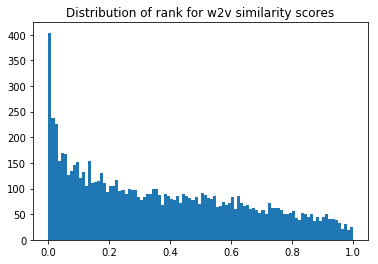

In [6]:
subset_df['w2v_similarity_rank_breast_cancer_percentile'] = subset_df['w2v_similarity_rank_breast_cancer']/subset_df.shape[0]
plt.hist(subset_df.w2v_similarity_rank_breast_cancer_percentile, bins=100)
plt.title('Distribution of rank for w2v similarity scores')

In [7]:
cancer_type = "Breast Cancer"
prefix="_".join(i.lower() for i in cancer_type.split())
subset_df = pd.read_csv(os.path.join(base_dir, 'models_lda/{}_lda_similarity_score.csv'.format(prefix)))

Text(0.5, 1.0, 'Distribution of rank for lda similarity scores for Breast Cancer')

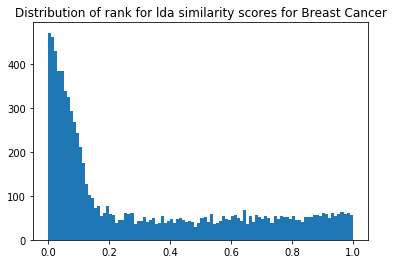

In [8]:
plt.hist(subset_df['lda_similarity_rank_{}_percentile'.format(prefix)], bins=100)
plt.title('Distribution of rank for lda similarity scores for {}'.format(cancer_type))

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
palette=['blue','red']
for i in range(2):
    sns.distplot(abstract_train_df[abstract_train_df[cancer_type]==i].text_length,color=palette[i],hist=False,ax=ax,label='Class{}'.format(i))
ax.set_title('Distribution of text length in each class',fontsize=12)
ax.set_xlabel('Number of words per text', fontsize=12)
ax.set_yticks([])
ax.set_ylabel('Density',fontsize=12)

In [227]:
def plot_w2v_similarity_rank(cancer_type):
    prefix="_".join(i.lower() for i in cancer_type.split())
    subset_df = pd.read_csv(os.path.join(base_dir, 'models_w2v/{}_w2v_similarity_score.csv'.format(prefix)))
    subset_df['w2v_similarity_rank_{}_percentile'.format(prefix)] = subset_df['w2v_similarity_rank_{}'.format(prefix)]/subset_df.shape[0]
    
    fig,ax=plt.subplots(1,1,figsize=(12,6))
    sns.distplot(subset_df['w2v_similarity_rank_{}_percentile'.format(prefix)], hist=True,kde=False,bins=int(subset_df.shape[0]/50) if subset_df.shape[0]>1000 else 20,ax=ax,hist_kws={'edgecolor':'black'})
    ax.set_xlim(0,1)
    ax.set_xlabel('w2v_similarity_score_rank_percentile_{}'.format(prefix), fontsize=12)
    ax.set_yticks([])
    ax.set_title('Distribution of W2V similarity score rank for {}'.format(cancer_type), fontsize=18)
    plt.show()
    fig.savefig(os.path.join(base_dir, 'models_w2v/{}_w2v_similarity_score.png'.format(prefix)))

In [ ]:
for cancer_type in cancer_types:
    plot_w2v_similarity_rank(cancer_type)

### KNN

In [118]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

In [ ]:
X=abstract_embedded_df.copy()
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

In [ ]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [35]:
from yellowbrick.cluster import KElbowVisualizer

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x123641cf8>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

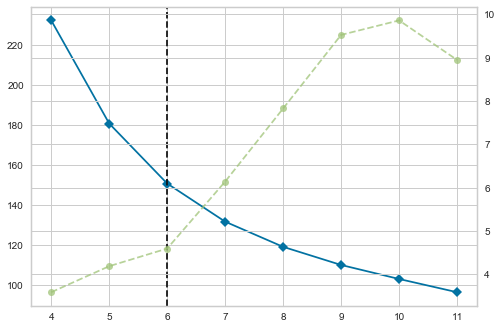

In [36]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))
visualizer.fit(X)
visualizer.show()

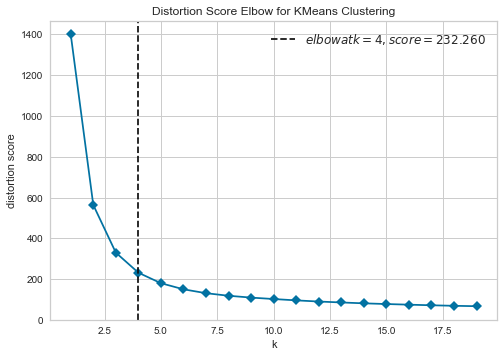

In [40]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20),metric='distortion',timings=False)
visualizer.fit(X)
visualizer.show()